In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from music21 import *

import os
import glob
import numpy as np

import matplotlib.pyplot as plt

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

import keras.utils.np_utils as np_utils

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# sess = tf.Session(config=config)
# set_session(sess)

Using TensorFlow backend.


In [3]:
DATASET_PATH = "/home/mmatsi/Dataset_Piano"

In [4]:
blacklist = [
]

In [5]:
notes = []

for file in glob.glob(f"{DATASET_PATH}/*.mid"):
    if file in blacklist:
        print("Skipped", file)
        continue
        
    print(file)
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    print(parts)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

/home/mmatsi/Dataset_Piano/Finalfantasy5gilgameshp.mid
<music21.stream.Score 0x7f930828a5c0>
/home/mmatsi/Dataset_Piano/FF4.mid
<music21.stream.Score 0x7f92f456b6d8>
/home/mmatsi/Dataset_Piano/gerudo.mid
<music21.stream.Score 0x7f92f4694f98>
/home/mmatsi/Dataset_Piano/Finalfantasy6fanfarecomplete.mid
<music21.stream.Score 0x7f92f43c20f0>
/home/mmatsi/Dataset_Piano/ViviinAlexandria.mid
<music21.stream.Score 0x7f92ea991be0>
/home/mmatsi/Dataset_Piano/Suteki_Da_Ne_(Piano_Version).mid
<music21.stream.Score 0x7f92ea9120f0>
/home/mmatsi/Dataset_Piano/FFIII_Edgar_And_Sabin_Piano.mid
<music21.stream.Score 0x7f92ea6f7fd0>
/home/mmatsi/Dataset_Piano/FF3_Third_Phase_Final_(Piano).mid
<music21.stream.Score 0x7f930817fb00>
/home/mmatsi/Dataset_Piano/FFIXQuMarshP.mid
<music21.stream.Score 0x7f92f46f39b0>
/home/mmatsi/Dataset_Piano/sobf.mid
<music21.stream.Score 0x7f92ea64e0f0>
/home/mmatsi/Dataset_Piano/In_Zanarkand.mid
<music21.stream.Score 0x7f92f4086978>
/home/mmatsi/Dataset_Piano/ff4-airship.mid

In [6]:
sequence_length = 100
# get all pitch names
pitchnames = sorted(set(item for item in notes))
n_vocab = len(pitchnames)
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# norma
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

In [7]:
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_______________________________________

In [8]:
filepath = "weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
history = model.fit(network_input, network_output, epochs=200, batch_size=128, callbacks=callbacks_list)


Epoch 1/200
57077/57077 [==============================] - 353s 6ms/step - loss: 4.7762
Epoch 2/200
57077/57077 [==============================] - 383s 7ms/step - loss: 4.7135
Epoch 3/200
57077/57077 [==============================] - 383s 7ms/step - loss: 4.7111
Epoch 4/200
57077/57077 [==============================] - 383s 7ms/step - loss: 4.7094
Epoch 5/200
57077/57077 [==============================] - 615s 11ms/step - loss: 4.7094
Epoch 6/200
57077/57077 [==============================] - 156s 3ms/step - loss: 4.7086
Epoch 7/200
57077/57077 [==============================] - 105s 2ms/step - loss: 4.7083
Epoch 8/200
57077/57077 [==============================] - 106s 2ms/step - loss: 4.7080
Epoch 9/200
57077/57077 [==============================] - 107s 2ms/step - loss: 4.7082
Epoch 10/200
57077/57077 [==============================] - 105s 2ms/step - loss: 4.7079
Epoch 11/200
57077/57077 [==============================] - 101s 2ms/step - loss: 4.7082
Epoch 12/200
57077/57077 [==

57077/57077 [==============================] - 92s 2ms/step - loss: 4.8110
Epoch 92/200
57077/57077 [==============================] - 92s 2ms/step - loss: 4.8085
Epoch 93/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.8070
Epoch 94/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.8050
Epoch 95/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.8028
Epoch 96/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.8012
Epoch 97/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.8008
Epoch 98/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.7957
Epoch 99/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.7974
Epoch 100/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.7967
Epoch 101/200
57077/57077 [==============================] - 91s 2ms/step - loss: 4.7955
Epoch 102/200
57077/57077 [================

57077/57077 [==============================] - 91s 2ms/step - loss: 0.1606
Epoch 184/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1647
Epoch 185/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1577
Epoch 186/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1572
Epoch 187/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1532
Epoch 188/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1556
Epoch 189/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1517
Epoch 190/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1552
Epoch 191/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1482
Epoch 192/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1483
Epoch 193/200
57077/57077 [==============================] - 91s 2ms/step - loss: 0.1457
Epoch 194/200
57077/57077 [========

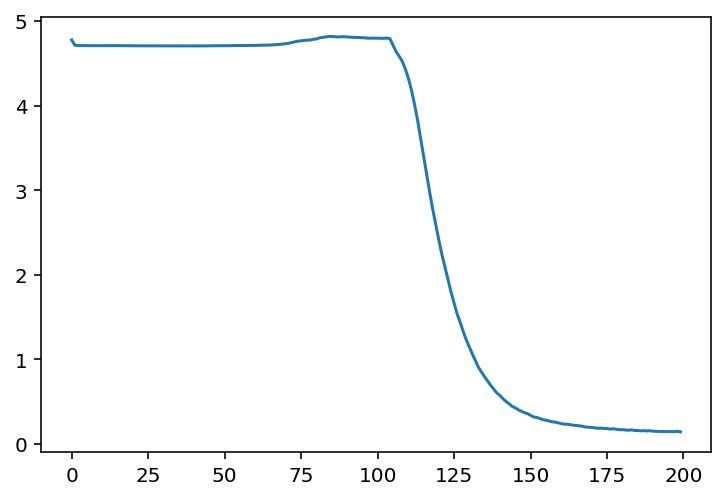

In [14]:
plt.plot(history.history['loss'])

In [ ]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# generate 500 notes
for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input[...,0], verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output+=(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]

In [ ]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')